In [1]:
import os
import numpy as np
import tensorflow as tf

from keras.api.optimizers import Adam
from keras.api.models import Sequential
from keras.api.losses import BinaryCrossentropy
from keras.api.layers import (
    Input,
    Dense,
    LeakyReLU,
    Reshape,
    Conv2D,
    Conv2DTranspose,
    BatchNormalization,
    LeakyReLU,
    Flatten,
)

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a PhysicalDeviceSpec to set the device
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)


sns.color_palette("rocket", as_cmap=True)

os.makedirs("images", exist_ok=True)

In [3]:
# Load and preprocess the MNIST dataset
def load_data():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
        "float32"
    )
    train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
    return train_images

In [4]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    # Set up the seaborn style
    sns.set_style("white")

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    # Reduce the gaps between images
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        sns.heatmap(
            predictions[i, :, :, 0] * 127.5 + 127.5,
            cbar=False,
            ax=ax,
            xticklabels=False,
            yticklabels=False,
        )
        ax.axis("off")

    plt.savefig(
        f"images/image_at_epoch_{epoch:02d}.png", bbox_inches="tight", pad_inches=0
    )


def plot_losses(gen_losses, disc_losses):
    gen_losses = np.array(gen_losses)
    disc_losses = np.array(disc_losses)
    plt.figure(figsize=(10, 6))
    plt.plot(gen_losses, label="Generator Loss", color="blue")
    plt.plot(disc_losses, label="Discriminator Loss", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [5]:
# Create the generator model
def create_generator():
    model = Sequential(
        [
            Input((100,)),
            Dense(256 * 7 * 7),
            LeakyReLU(0.01),
            Reshape((7, 7, 256)),
            Conv2DTranspose(128, kernel_size=5, strides=1, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2DTranspose(
                1, kernel_size=5, strides=2, padding="same", activation="tanh"
            ),
        ]
    )
    return model


# Create the discriminator model
def create_discriminator():
    model = Sequential(
        [
            Input((28, 28, 1)),
            Conv2D(32, kernel_size=3, strides=2, padding="same"),
            LeakyReLU(0.01),
            Conv2D(64, kernel_size=3, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2D(128, kernel_size=3, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Flatten(),
            Dense(1),
        ]
    )
    return model

In [6]:
# Define the loss functions
cross_entropy = BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
generator_optimizer = Adam(learning_rate=0.0002)
discriminator_optimizer = Adam(learning_rate=0.0002)


# Training step
@tf.function
def train_step(images, generator, discriminator, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


# Training loop
def train(dataset, epochs, batch_size, generator, discriminator):
    global gen_losses, disc_losses
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(
                image_batch, generator, discriminator, batch_size
            )
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")
        generate_and_save_images(generator, epoch + 1, tf.random.normal([16, 100]))

2024-06-02 23:21:44.537519: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-06-02 23:21:44.537541: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-02 23:21:44.537546: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-02 23:21:44.537564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 23:21:44.537577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-06-02 23:21:45.505493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-02 23:22:12.654050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Gen Loss: 2.104503870010376, Disc Loss: 0.6143665313720703


2024-06-02 23:22:34.349875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Gen Loss: 1.8998706340789795, Disc Loss: 0.6458369493484497


2024-06-02 23:22:56.439934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Gen Loss: 1.175774097442627, Disc Loss: 0.9369198083877563


2024-06-02 23:23:18.371604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Gen Loss: 0.8495974540710449, Disc Loss: 1.0472545623779297


2024-06-02 23:23:39.154473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Gen Loss: 0.9418724775314331, Disc Loss: 0.9269340634346008


2024-06-02 23:24:01.308588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Gen Loss: 0.7129833698272705, Disc Loss: 1.336049199104309


2024-06-02 23:24:22.890590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Gen Loss: 0.8756514191627502, Disc Loss: 1.2638475894927979


2024-06-02 23:24:44.649367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Gen Loss: 0.8639804720878601, Disc Loss: 1.2727323770523071


2024-06-02 23:25:07.219201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Gen Loss: 0.8396776914596558, Disc Loss: 1.373239278793335


2024-06-02 23:25:28.431235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10, Gen Loss: 0.7486410140991211, Disc Loss: 1.2846368551254272


2024-06-02 23:25:50.514052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11, Gen Loss: 0.7689510583877563, Disc Loss: 1.360450029373169


2024-06-02 23:26:12.962488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12, Gen Loss: 0.8451012372970581, Disc Loss: 1.140845775604248


2024-06-02 23:26:33.883976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13, Gen Loss: 0.7934625744819641, Disc Loss: 1.24209463596344


2024-06-02 23:26:56.632025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14, Gen Loss: 0.8568221926689148, Disc Loss: 1.2458919286727905


2024-06-02 23:27:18.825514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15, Gen Loss: 0.7170228362083435, Disc Loss: 1.2519638538360596


2024-06-02 23:27:39.845121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Gen Loss: 0.7470986843109131, Disc Loss: 1.3688137531280518


2024-06-02 23:28:02.374036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17, Gen Loss: 0.8477252721786499, Disc Loss: 1.2637693881988525


2024-06-02 23:28:24.267745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18, Gen Loss: 0.7653480768203735, Disc Loss: 1.452751636505127


2024-06-02 23:28:45.999333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19, Gen Loss: 0.8211697340011597, Disc Loss: 1.3820126056671143


2024-06-02 23:29:08.562192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20, Gen Loss: 0.7610800266265869, Disc Loss: 1.2327044010162354


2024-06-02 23:29:29.800082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/var/folders/qy/r_xk2ycs2zng63w975js4pqw0000gn/T/ipykernel_38276/3882121420.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(4, 4, figsize=(8, 8))


Epoch 21, Gen Loss: 0.7250799536705017, Disc Loss: 1.2421767711639404


2024-06-02 23:29:52.003569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22, Gen Loss: 0.8820146322250366, Disc Loss: 1.3110054731369019


2024-06-02 23:30:14.558343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23, Gen Loss: 0.7832268476486206, Disc Loss: 1.312005639076233


2024-06-02 23:30:35.458314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24, Gen Loss: 0.7297881841659546, Disc Loss: 1.3347210884094238


2024-06-02 23:30:58.121495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25, Gen Loss: 0.7450008392333984, Disc Loss: 1.2449665069580078


2024-06-02 23:31:20.686486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26, Gen Loss: 0.7567743062973022, Disc Loss: 1.326348066329956


2024-06-02 23:31:42.247590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27, Gen Loss: 0.7214272618293762, Disc Loss: 1.2277213335037231


2024-06-02 23:32:04.786185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28, Gen Loss: 0.786231279373169, Disc Loss: 1.2750135660171509


2024-06-02 23:32:26.508800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29, Gen Loss: 0.783395528793335, Disc Loss: 1.4083728790283203


2024-06-02 23:32:48.616676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30, Gen Loss: 0.7332974672317505, Disc Loss: 1.357622742652893


2024-06-02 23:33:11.209380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31, Gen Loss: 0.8257442116737366, Disc Loss: 1.3762773275375366


2024-06-02 23:33:32.224037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32, Gen Loss: 0.7578046321868896, Disc Loss: 1.373253583908081


2024-06-02 23:33:54.765763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33, Gen Loss: 0.7271941304206848, Disc Loss: 1.4338884353637695


2024-06-02 23:34:17.318108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34, Gen Loss: 0.741989016532898, Disc Loss: 1.3506710529327393


2024-06-02 23:34:38.318787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35, Gen Loss: 0.6804907917976379, Disc Loss: 1.4524199962615967


2024-06-02 23:35:01.057302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36, Gen Loss: 0.7985090017318726, Disc Loss: 1.4206551313400269


2024-06-02 23:35:23.080268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37, Gen Loss: 0.7051125764846802, Disc Loss: 1.3619279861450195


2024-06-02 23:35:44.839552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38, Gen Loss: 0.7260870933532715, Disc Loss: 1.226580023765564


2024-06-02 23:36:07.635593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39, Gen Loss: 0.75282222032547, Disc Loss: 1.338797926902771


2024-06-02 23:36:29.205768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40, Gen Loss: 0.7249642014503479, Disc Loss: 1.2757956981658936


2024-06-02 23:36:51.575524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41, Gen Loss: 0.7857016921043396, Disc Loss: 1.2767701148986816


2024-06-02 23:37:14.916386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42, Gen Loss: 0.8512442111968994, Disc Loss: 1.308899164199829


2024-06-02 23:37:36.574510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43, Gen Loss: 0.7535223364830017, Disc Loss: 1.2357323169708252


2024-06-02 23:37:58.783880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44, Gen Loss: 0.8056598901748657, Disc Loss: 1.2192738056182861


2024-06-02 23:38:20.734507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45, Gen Loss: 0.806337833404541, Disc Loss: 1.3424367904663086


2024-06-02 23:38:41.804566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46, Gen Loss: 0.7093212604522705, Disc Loss: 1.3152501583099365


2024-06-02 23:39:04.095634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47, Gen Loss: 0.7188726663589478, Disc Loss: 1.4069759845733643


2024-06-02 23:39:25.825239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48, Gen Loss: 0.7228279113769531, Disc Loss: 1.336967945098877


2024-06-02 23:39:47.325761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49, Gen Loss: 0.6899981498718262, Disc Loss: 1.212988018989563


2024-06-02 23:40:09.540185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50, Gen Loss: 0.8736953139305115, Disc Loss: 1.4848823547363281


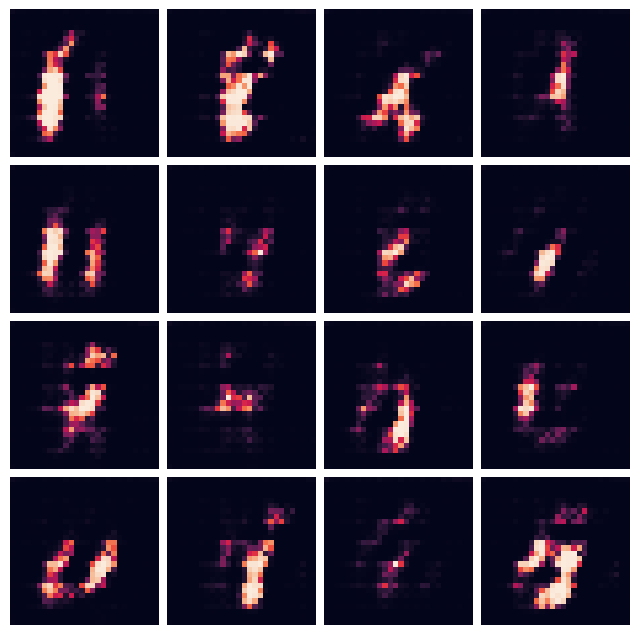

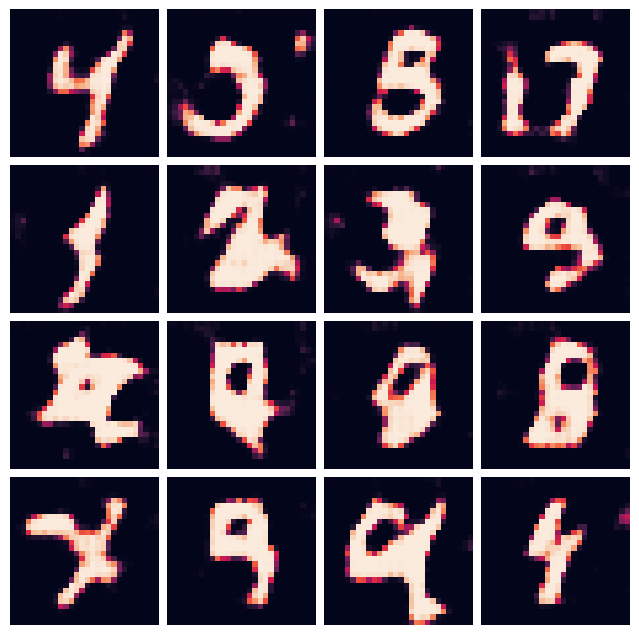

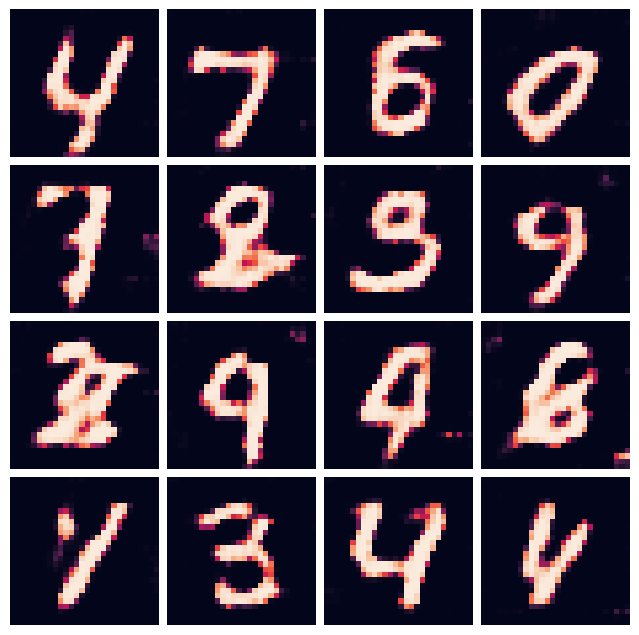

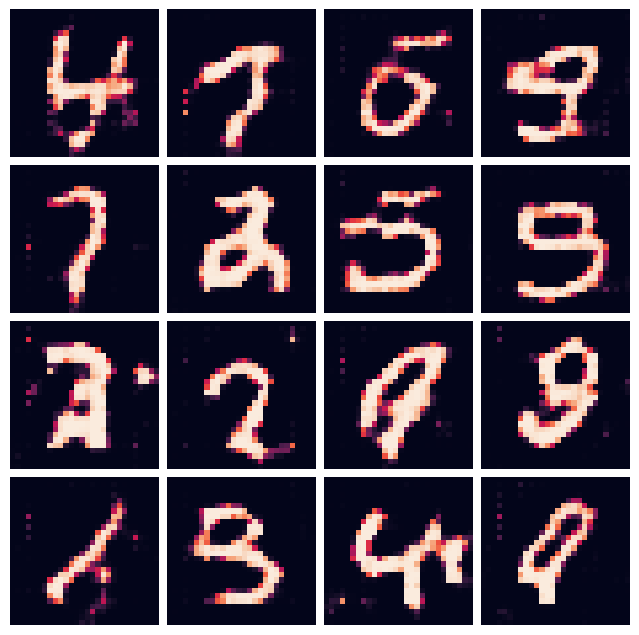

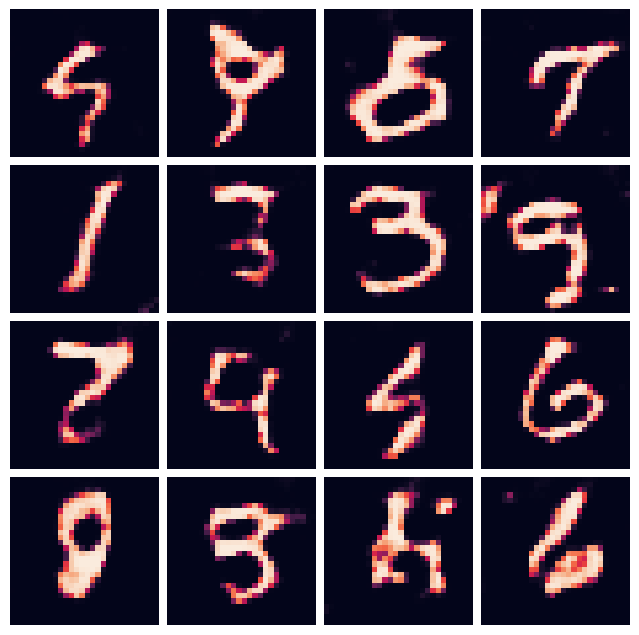

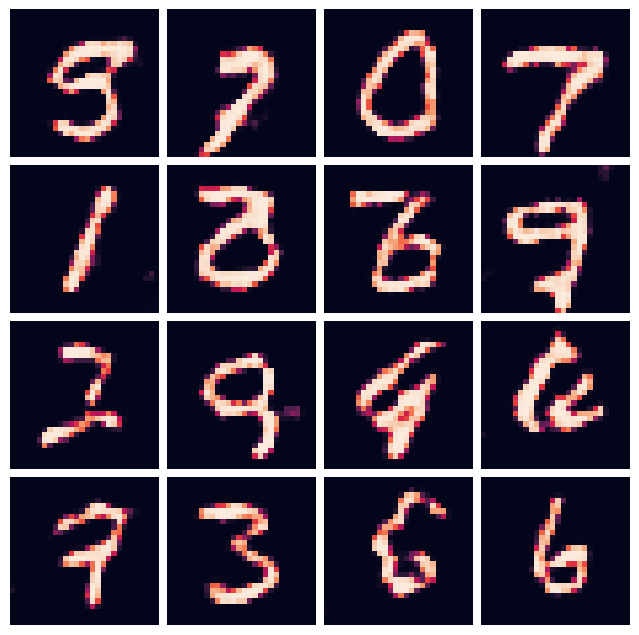

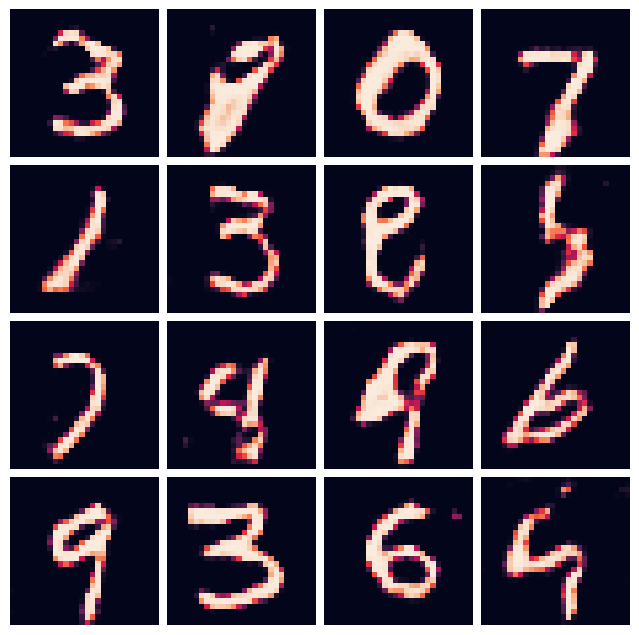

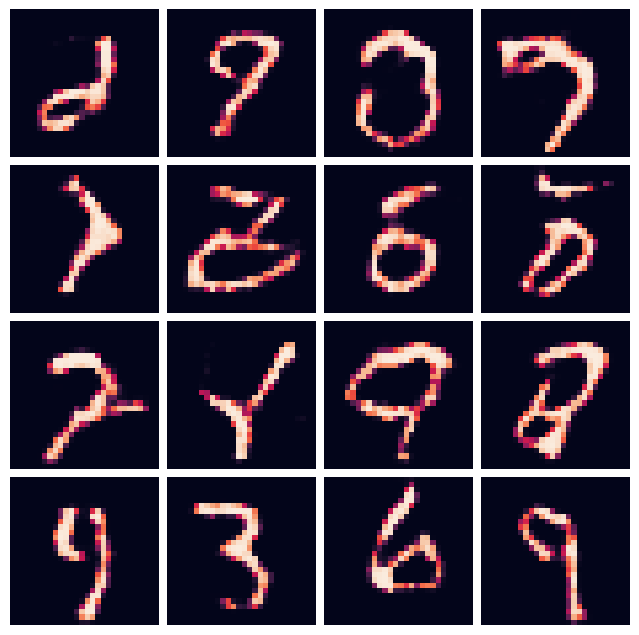

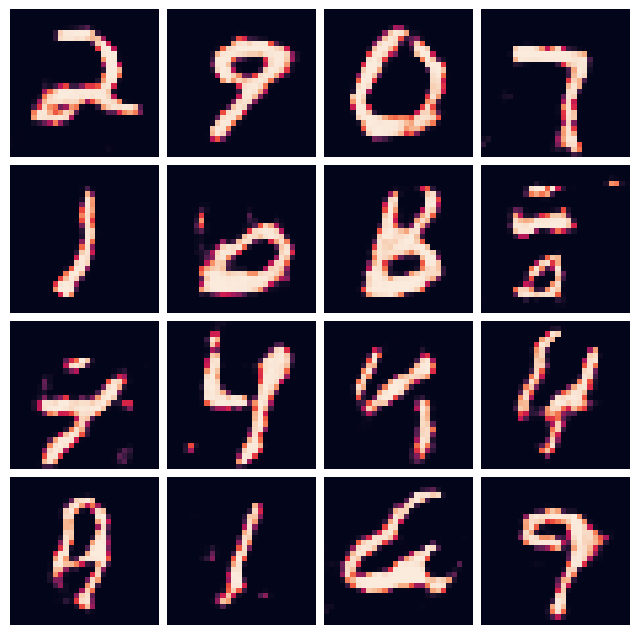

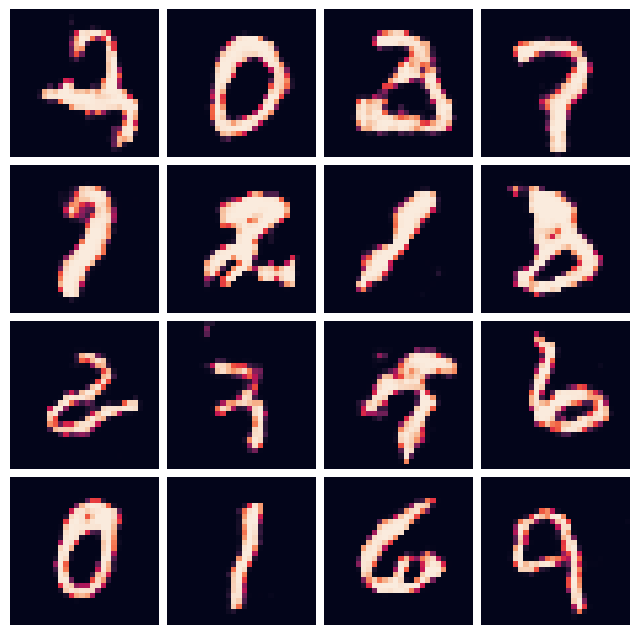

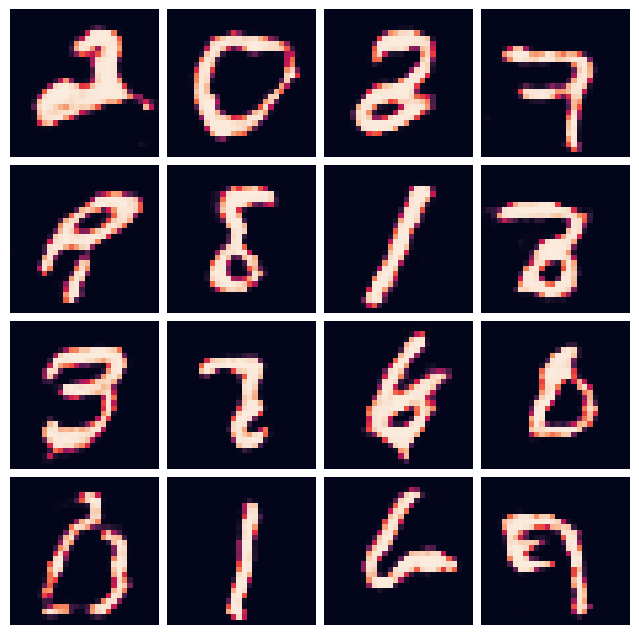

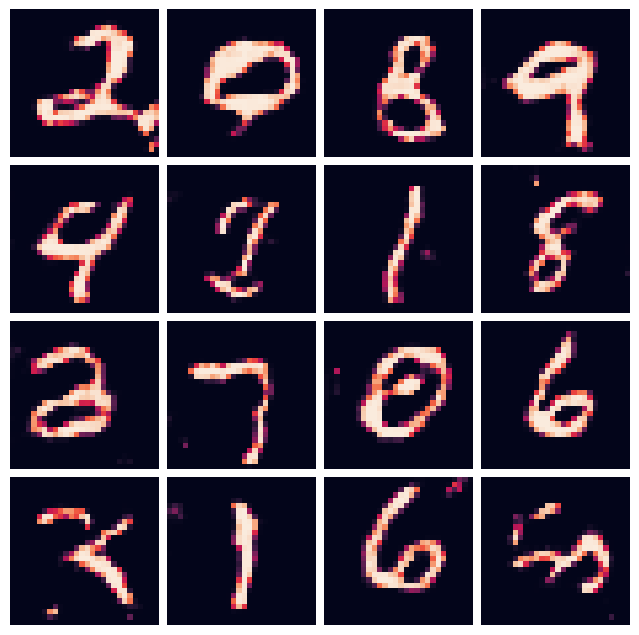

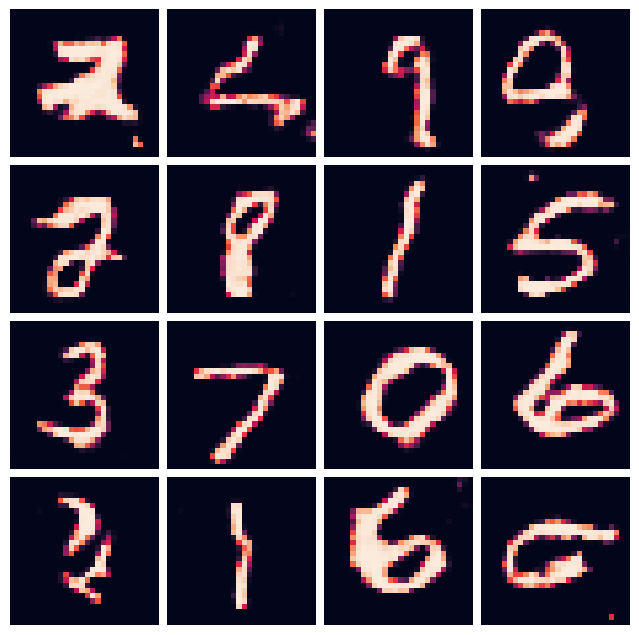

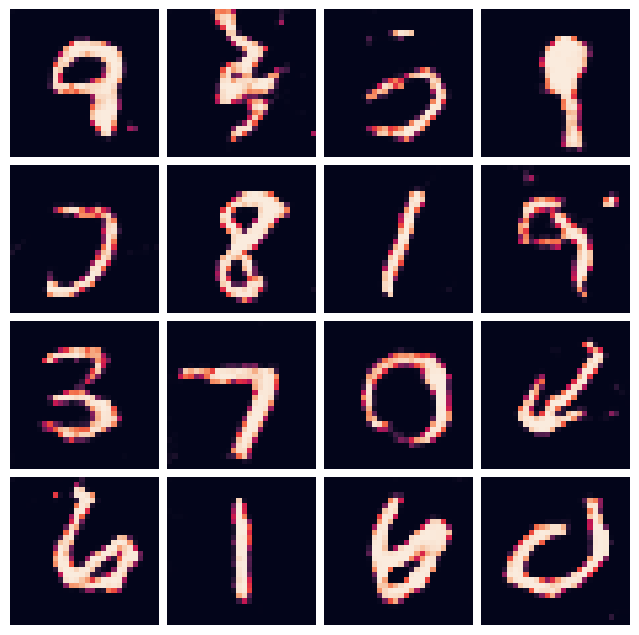

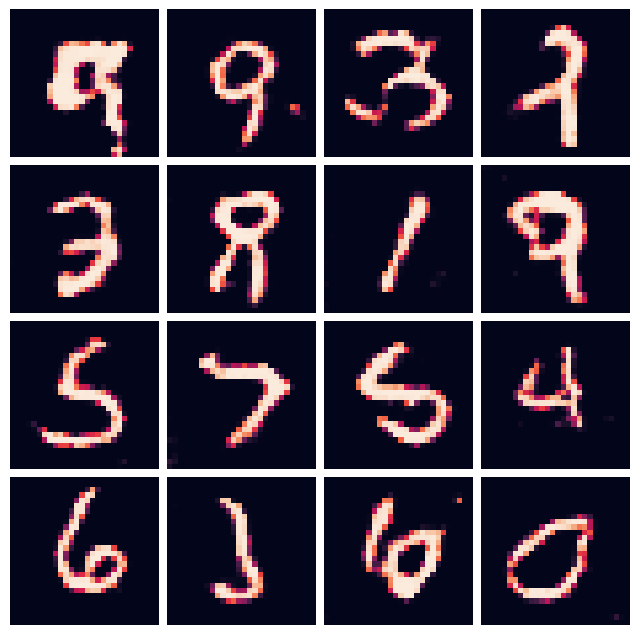

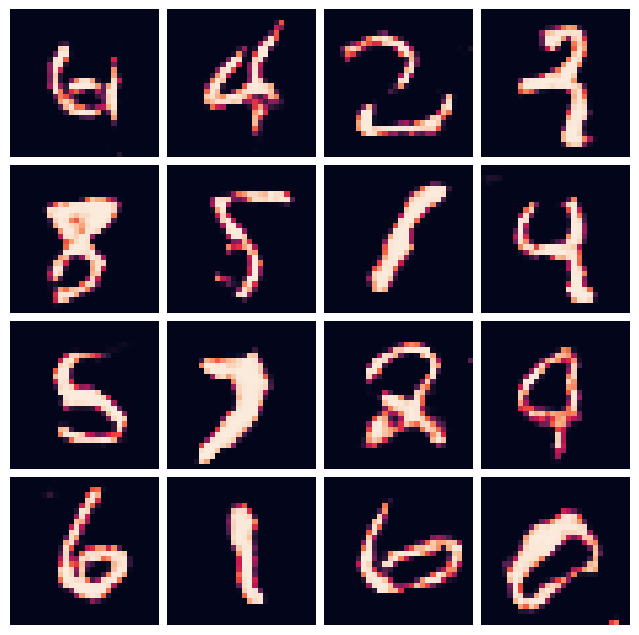

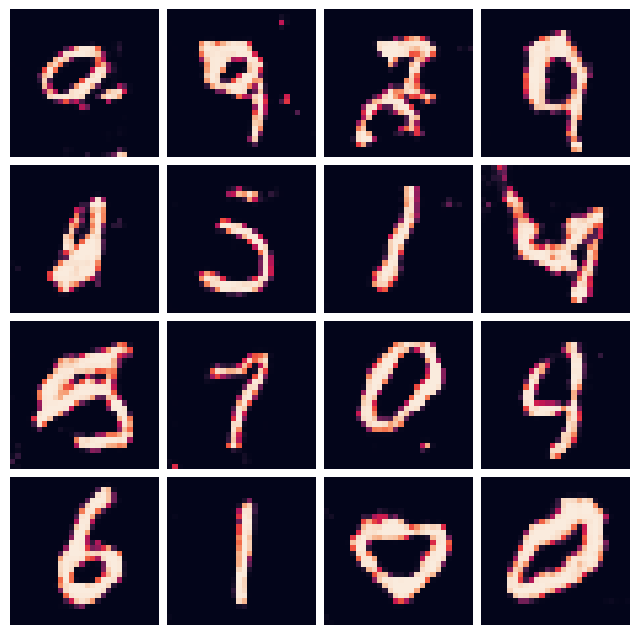

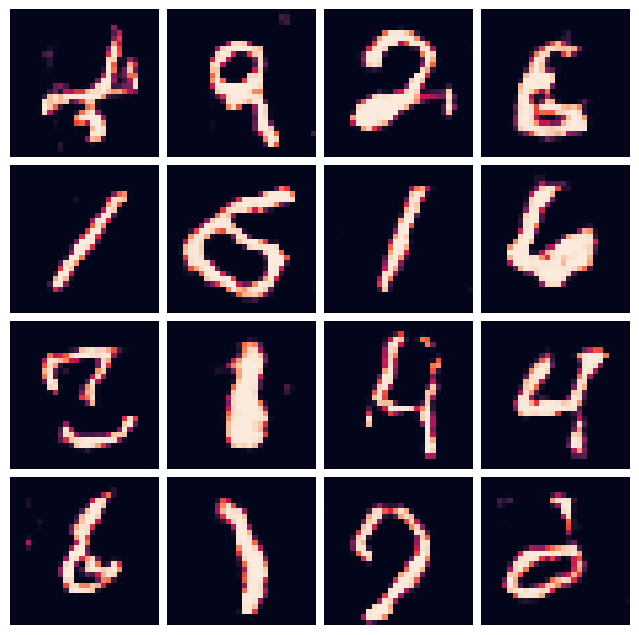

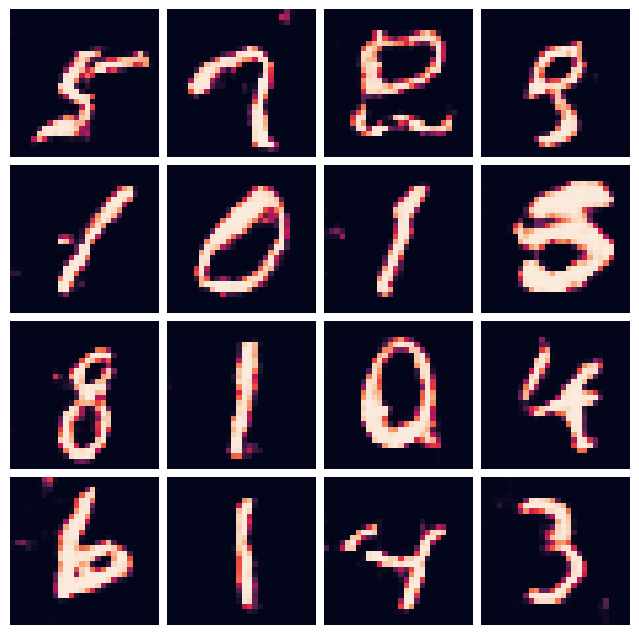

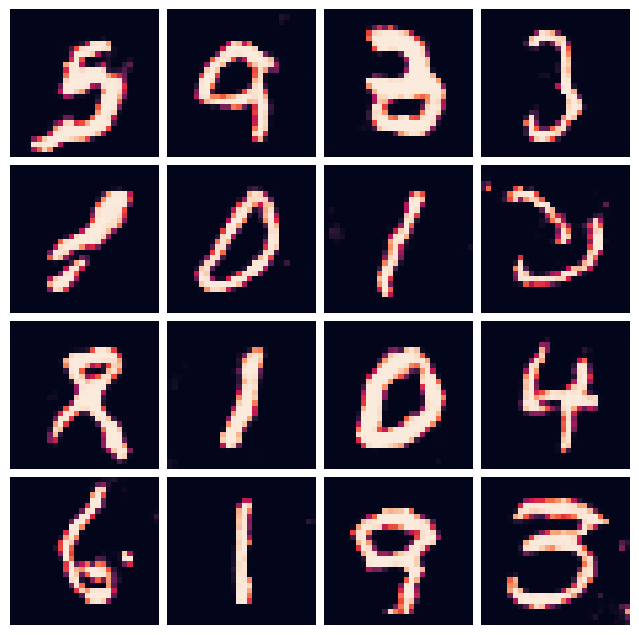

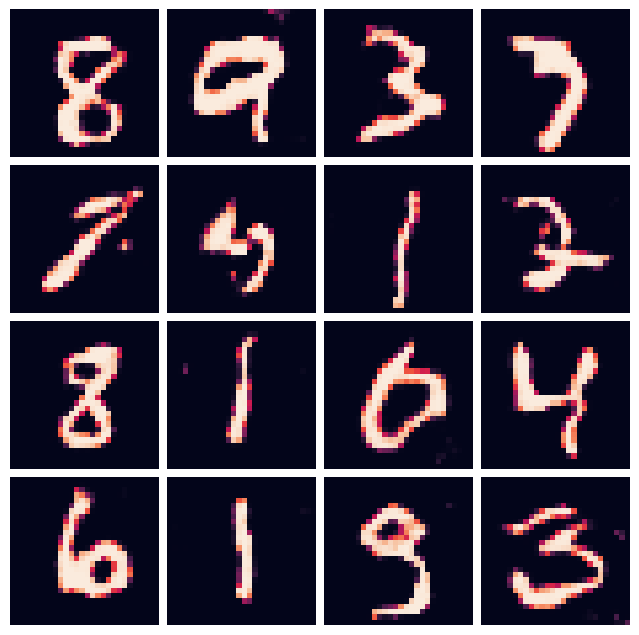

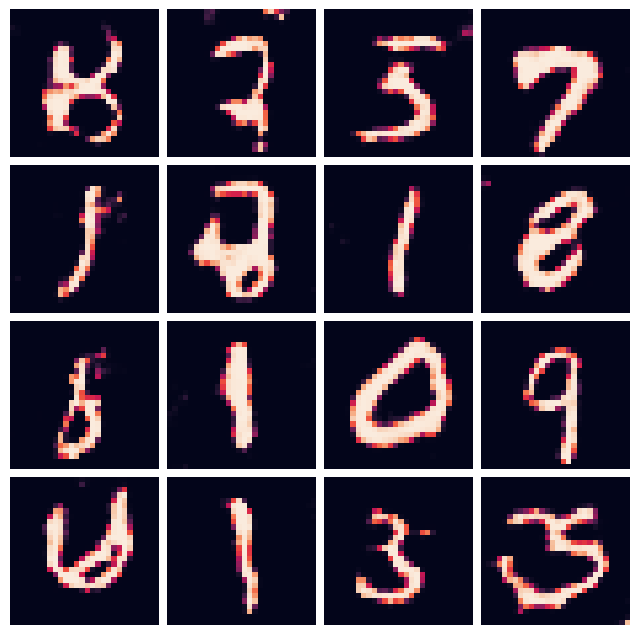

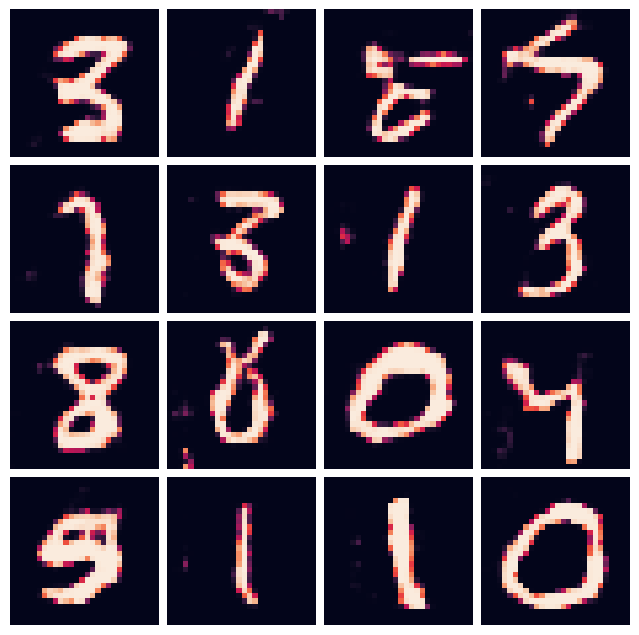

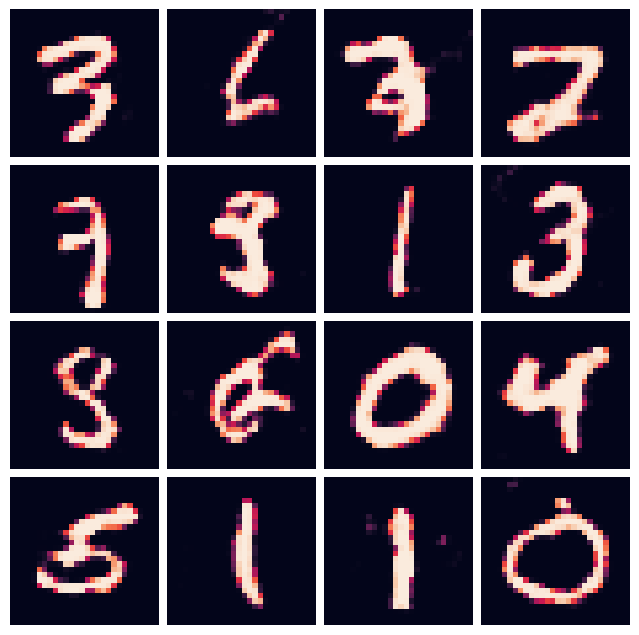

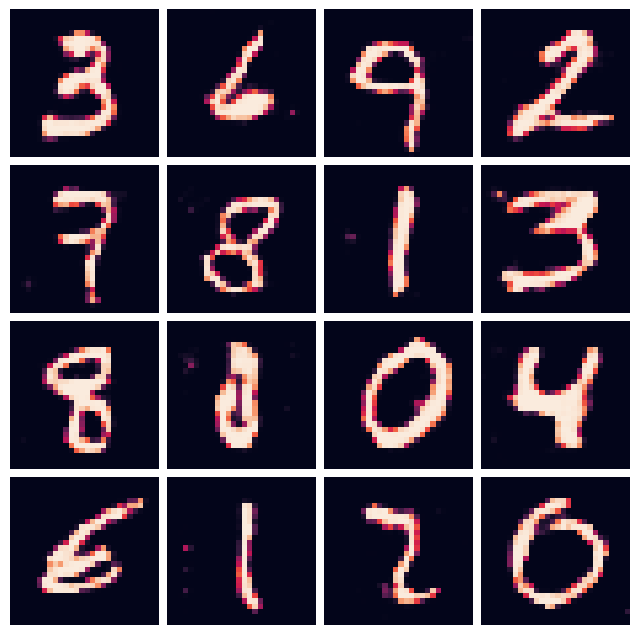

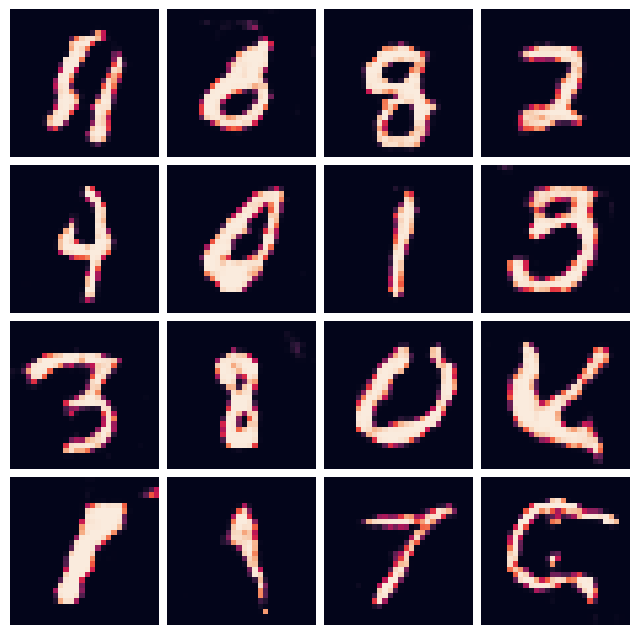

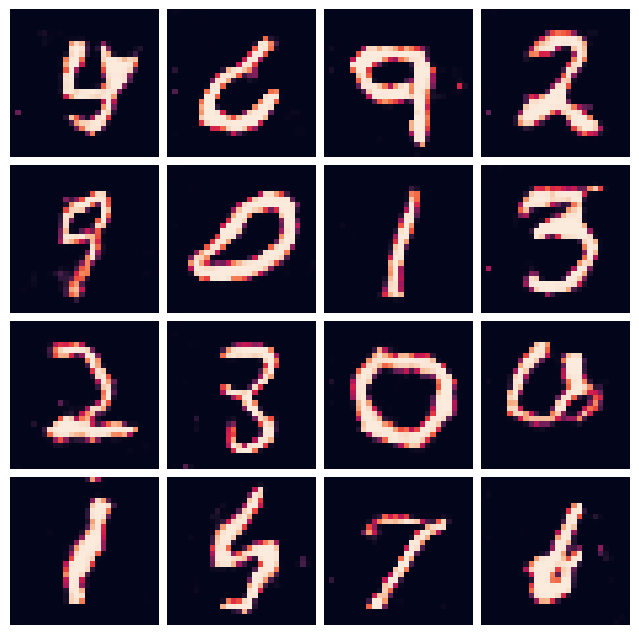

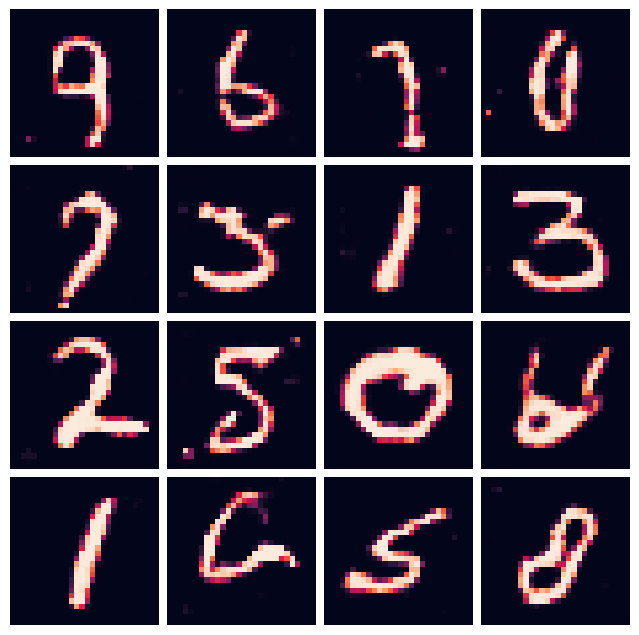

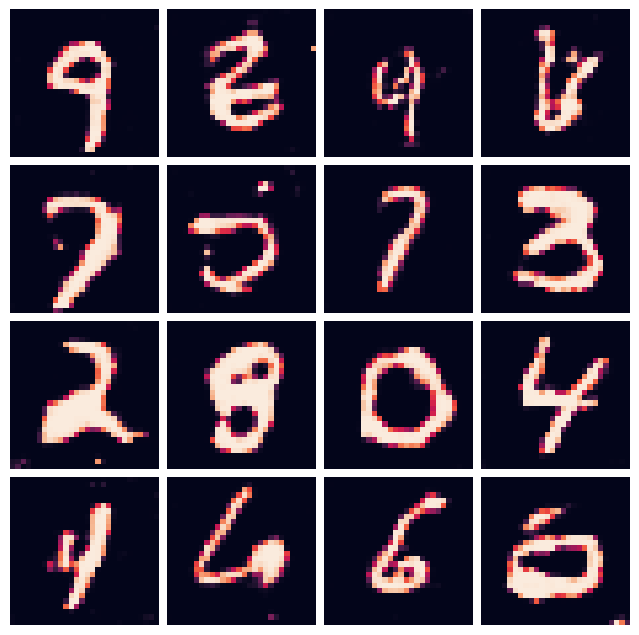

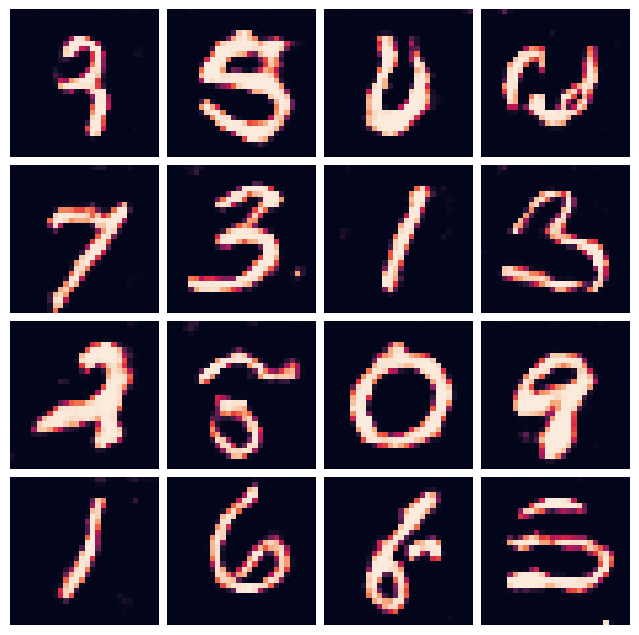

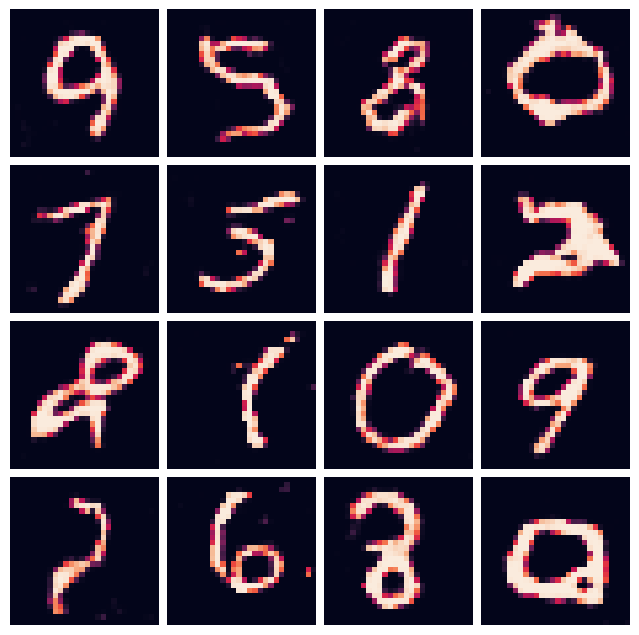

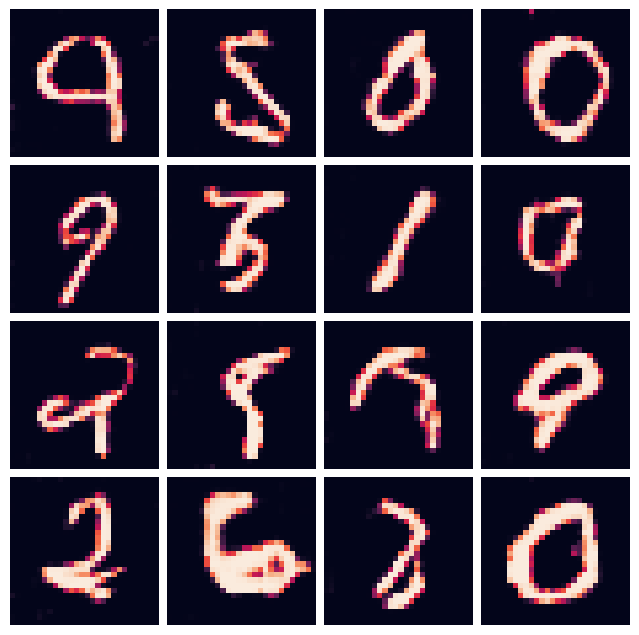

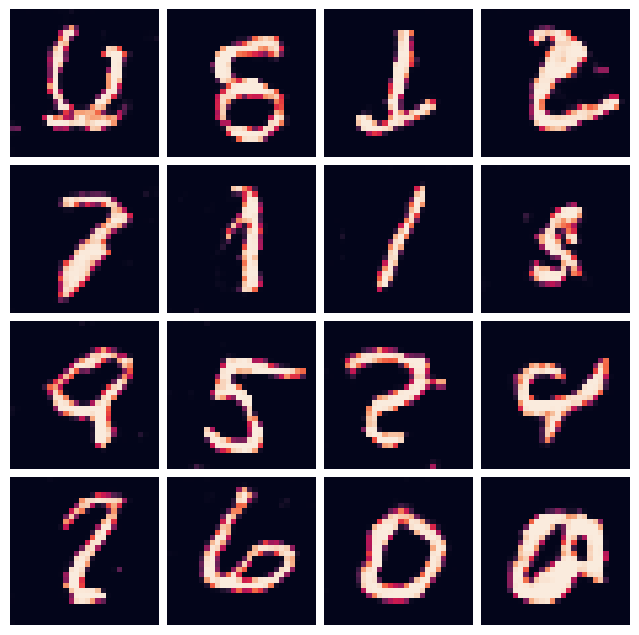

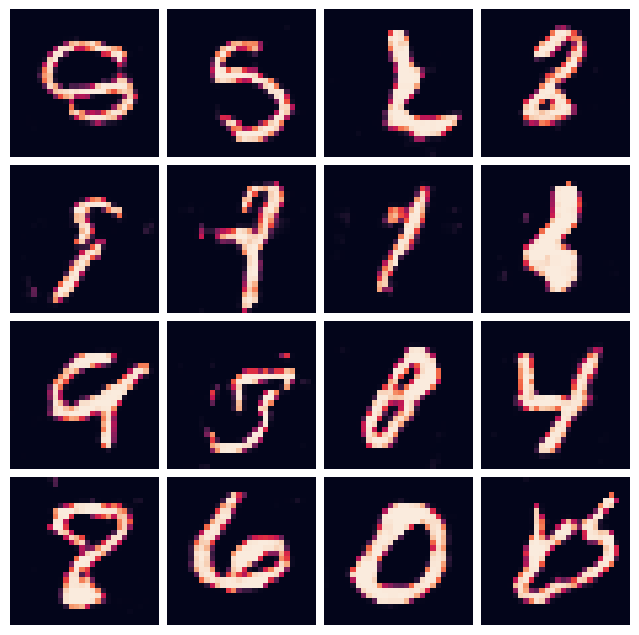

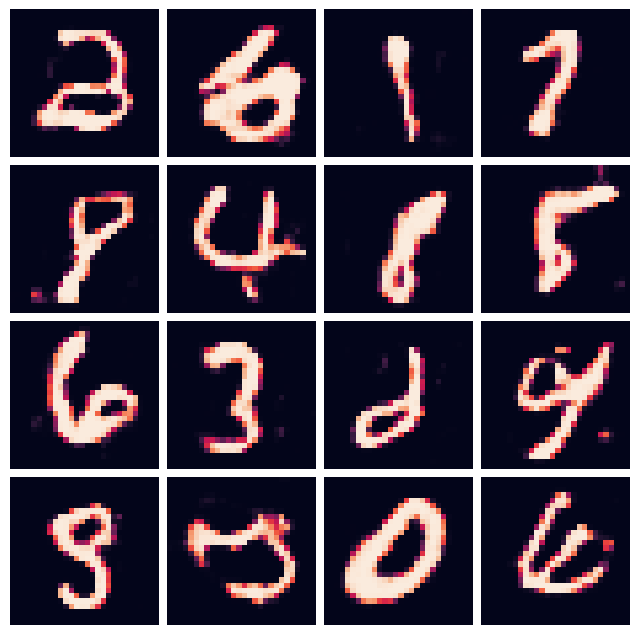

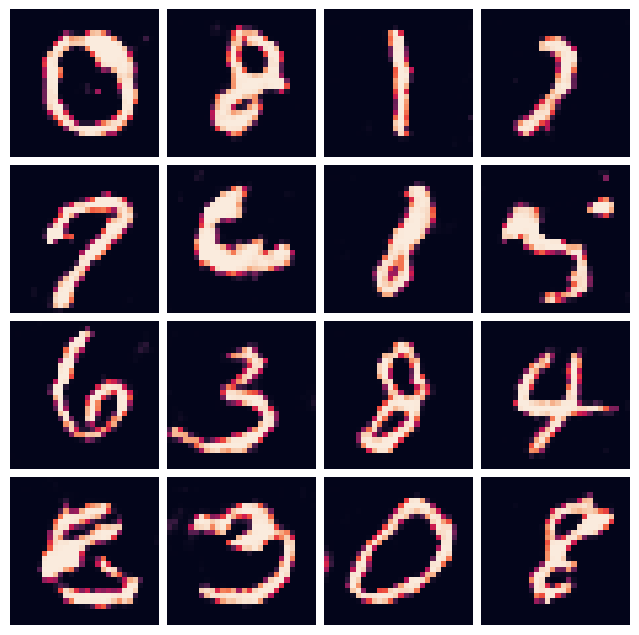

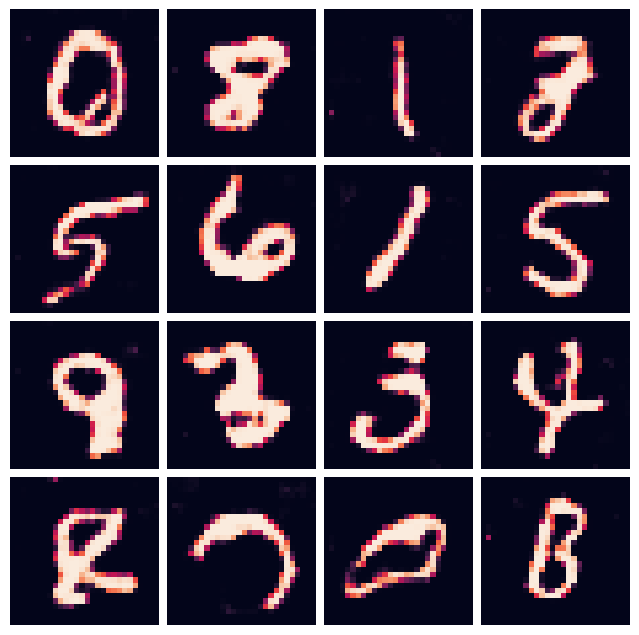

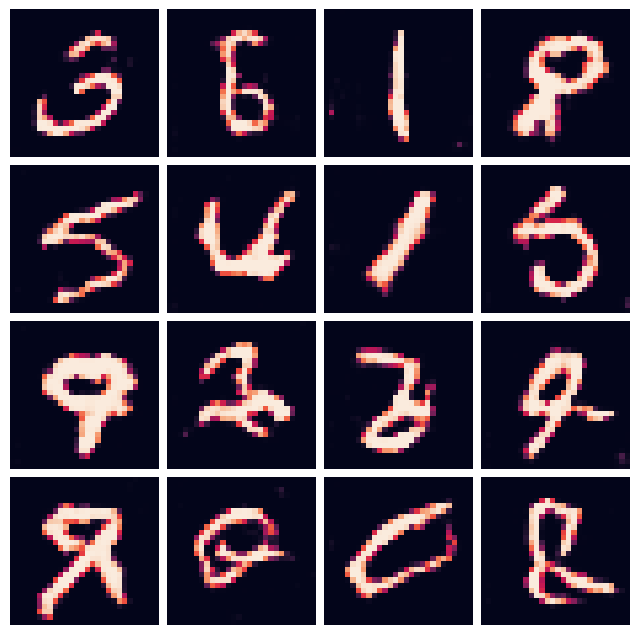

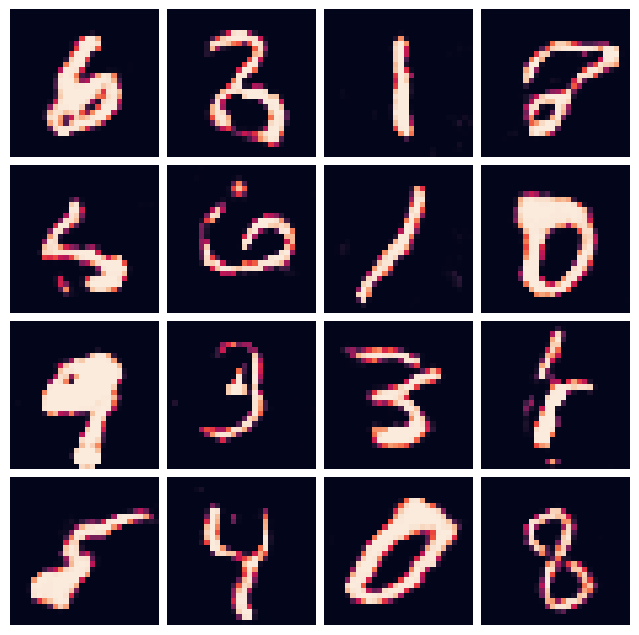

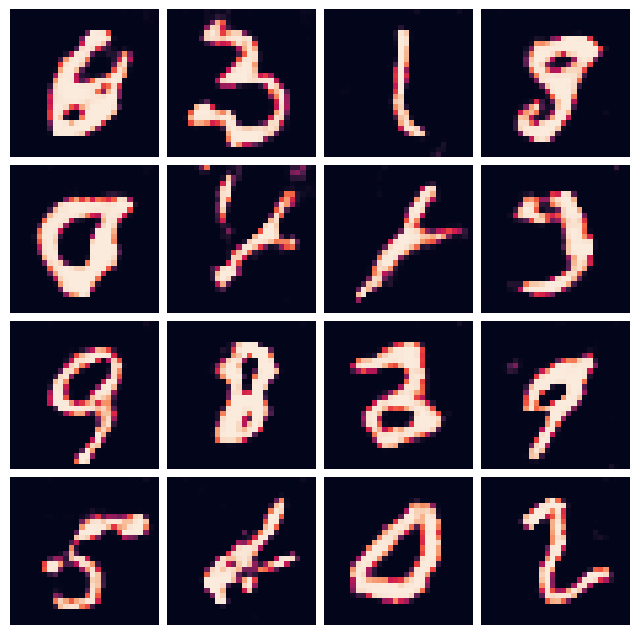

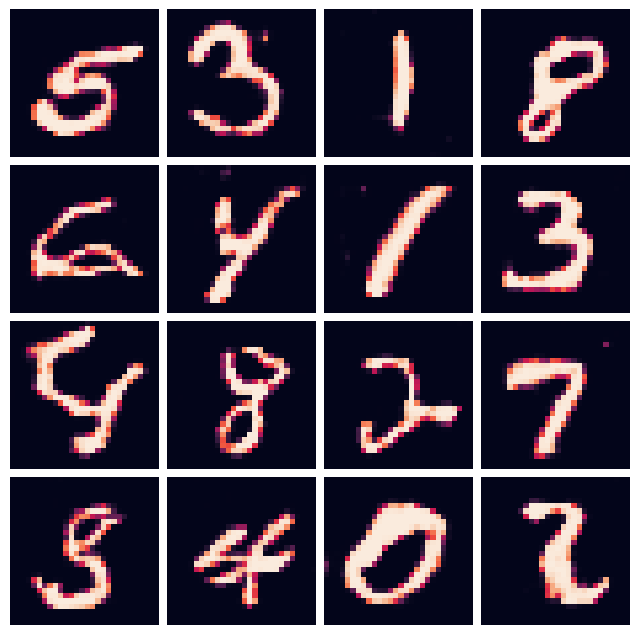

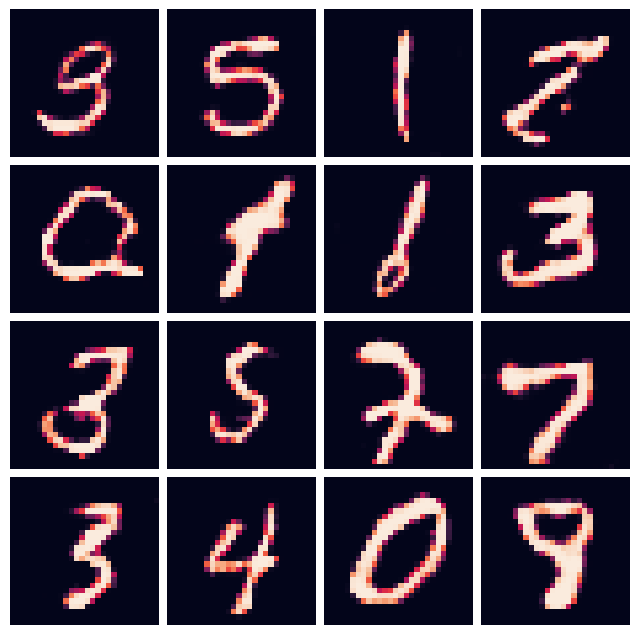

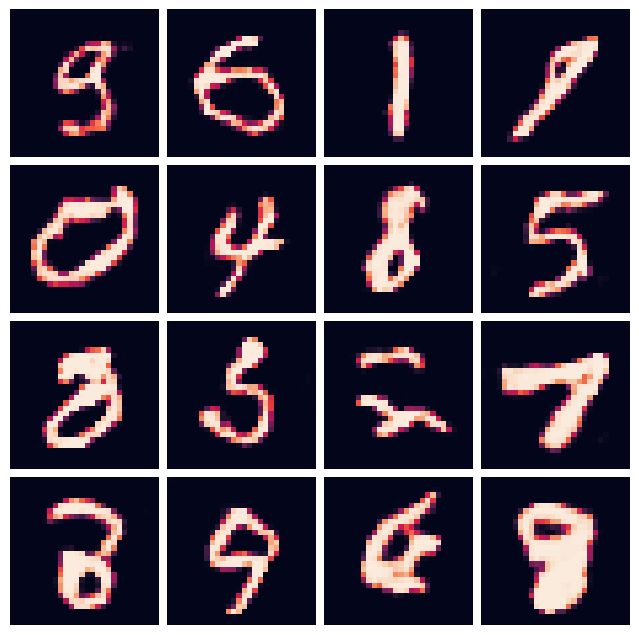

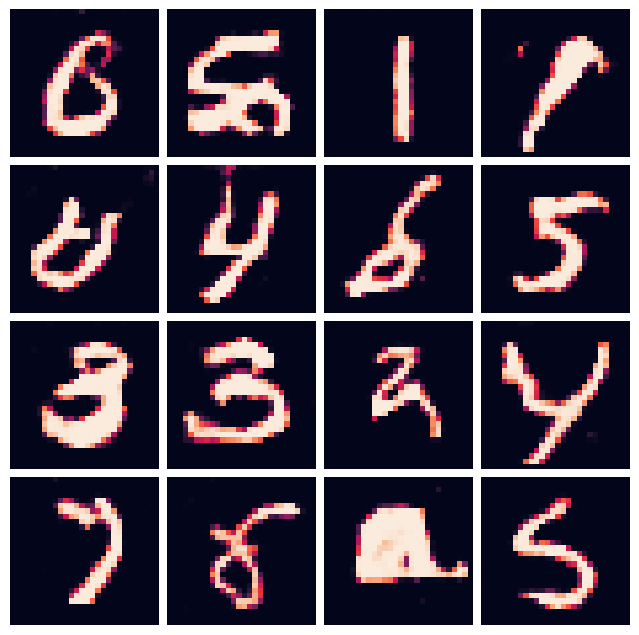

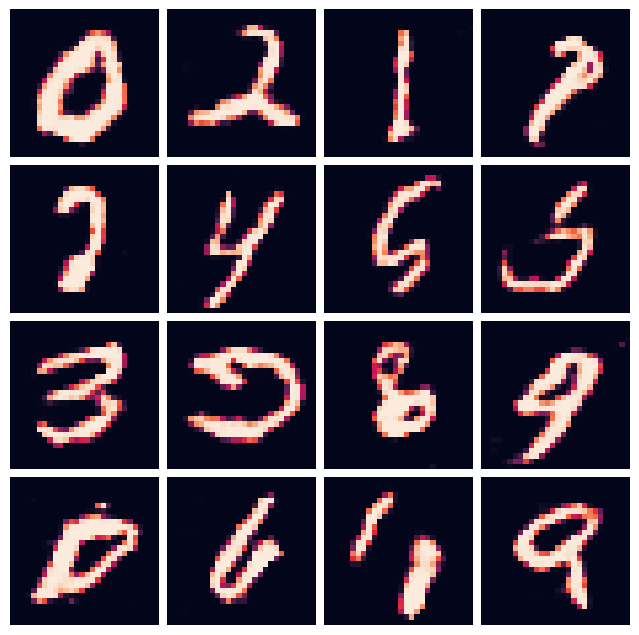

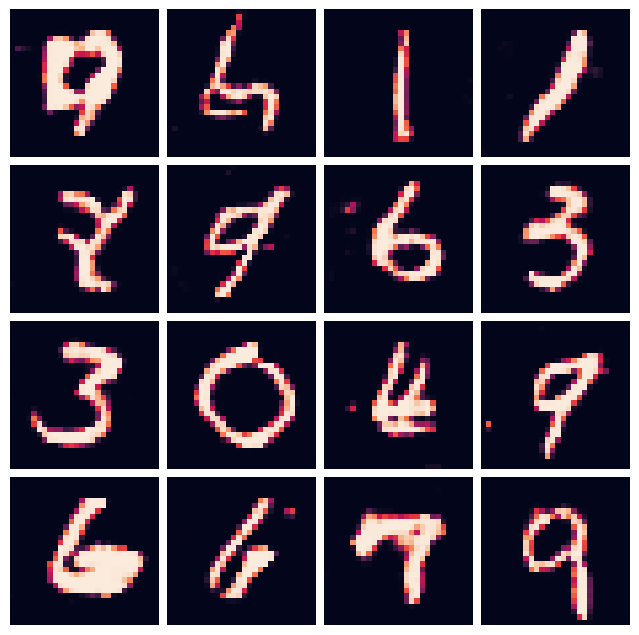

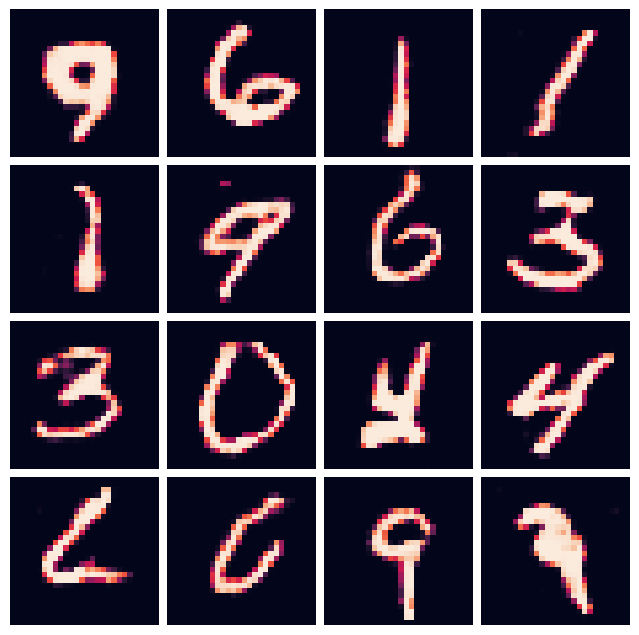

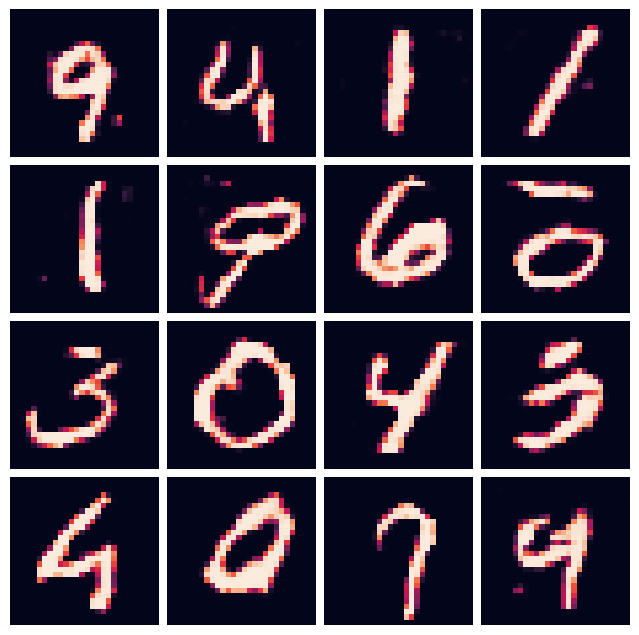

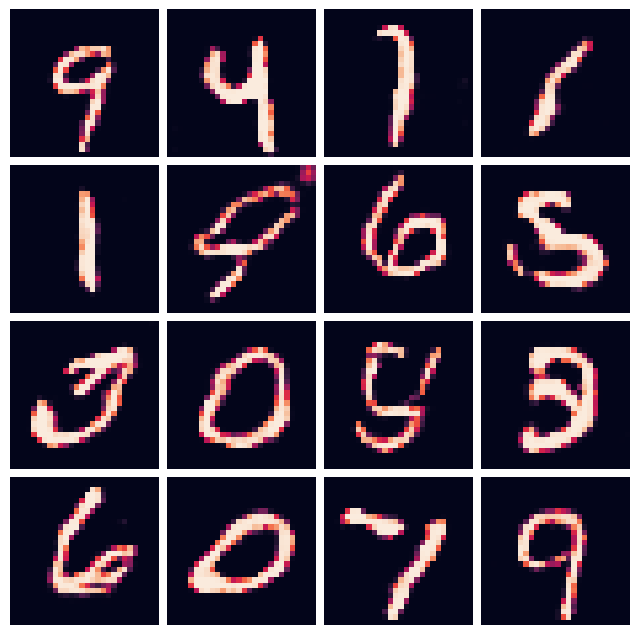

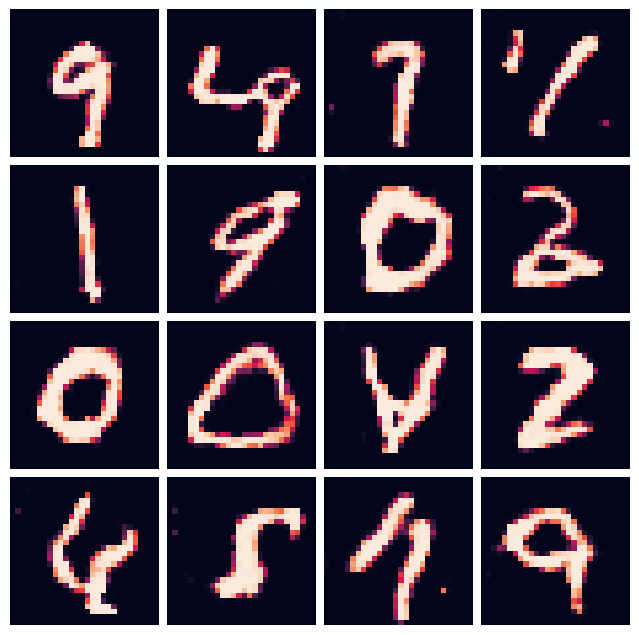

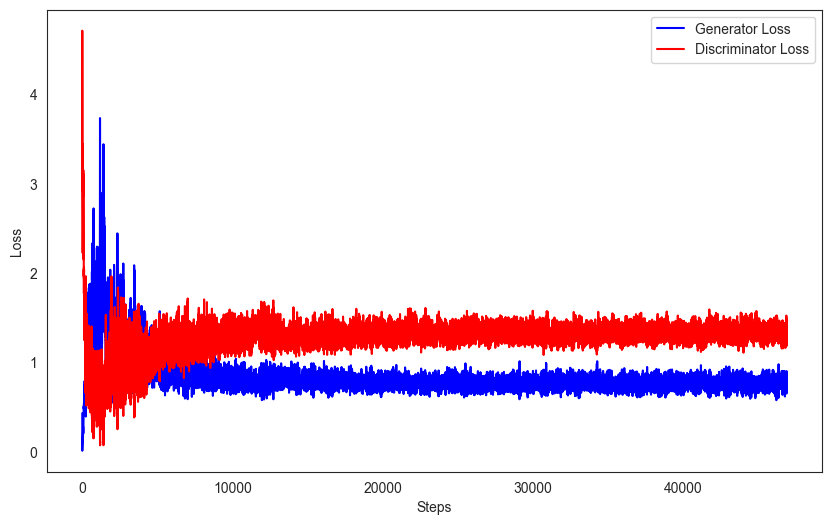

In [8]:
buffer_size = 60_000
batch_size = 64
epochs = 50

gen_losses = []
disc_losses = []

train_images = load_data()
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(buffer_size)
    .batch(batch_size)
)
generator = create_generator()
discriminator = create_discriminator()

train(train_dataset, epochs, batch_size, generator, discriminator)
plot_losses(gen_losses, disc_losses)